In [ ]:
import os

import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image


class OralCancerImageDataset(Dataset):
    def __init__(self, img_dir, labels_file=None, transform=None,
                 target_transform=None, indices=None):
        self.img_dir = img_dir
        self.labels = pd.read_csv(labels_file) if labels_file else None
        self.transform = transform
        self.target_transform = target_transform
        self.indices = indices

    def __len__(self):
        if self.indices is not None:
            return len(self.indices)

        if self.labels is not None:
            return len(self.labels)

        return len([name for name in os.listdir(self.img_dir)
                    if os.path.isfile(os.path.join(self.img_dir, name))])

    def __getitem__(self, index):
        if self.indices is not None:
            index = self.indices[index]
        if self.labels is not None:
            img_path = img_path = os.path.join(self.img_dir,
                                    f'{self.labels.iloc[index, 0]}')
            label = self.labels.iloc[index, 1]
        else:
            img_path = img_path = os.path.join(self.img_dir,
                                    f'image_{index}.jpg')
            label = f'image_{index}.jpg'

        image = (read_image(img_path)/255.0)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        sample = {'image': image, 'label': label}

        return sample

In [ ]:
path_to_csv = '/kaggle/input/cancer-classification-challenge-2024/train.csv'
path_to_train_images = '/kaggle/input/cancer-classification-challenge-2024/train'
path_to_test_images = '/kaggle/input/cancer-classification-challenge-2024/test'


# optimizers.py
import sklearn.metrics as skl_m
import torch
from torch import nn


def train(dataloader, model, loss_fn, optimizer, device, verbose=False):
    training_losses, metrics = [], []

    for i, batch in enumerate(dataloader):
        X, y = batch['image'], batch['label']
        X, y = X.to(device), y.to(device)

        prediction = model(X)
        training_loss = loss_fn(prediction, y)

        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()

        training_loss = training_loss.item()
        y_pred = nn.Softmax(dim=1)(prediction)[:, 1]
        training_losses.append(training_loss)
        metric_score = skl_m.mean_squared_error(y.cpu().detach(),
                                                y_pred.cpu().detach())
        metrics.append(metric_score)

    training_loss = sum(training_losses) / len(training_losses)
    metric = sum(metrics) / len(metrics)

    if verbose:
        print(f"Training loss: {training_loss:>5f}, "
              f"Training metric: {metric:>5f}")

    return metric, training_loss


def validate(dataloader, model, loss_fn, device, verbose=False):
    model.eval()
    validation_losses, metrics = [], []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            X, y = batch['image'], batch['label']
            X, y = X.to(device), y.to(device)

            prediction = model(X)
            y_pred = nn.Softmax(dim=1)(prediction)[:, 1]
            validation_losses.append(loss_fn(prediction, y).item())
            metric_score = skl_m.mean_squared_error(y.cpu().detach(),
                                                    y_pred.cpu().detach())
            metrics.append(metric_score)

    validation_loss = sum(validation_losses) / len(validation_losses)
    metric = sum(metrics)/len(metrics)

    if verbose:
        print(f"Validation loss: {validation_loss:>5f}, "
              f"Validation metric: {metric:>5f}")

    return metric, validation_loss

In [ ]:
import random
import torchvision.transforms.functional as TF


class DiscreteRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

In [ ]:
import torch
from collections import OrderedDict

class ConvolutionalClassification(nn.Module):
    def __init__(self, class_count):
        super(ConvolutionalClassification, self).__init__()
        self.avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool3d((class_count,1,1)),
            nn.Flatten(start_dim=1)
        )
    def forward(self, x):
        x = self.avg_pool(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, layer_count, channel_num, filter_size=3):
        super(ResidualBlock, self).__init__()

        conv_list = []
        for i in range(layer_count):
            conv_list.append((f'conv{i}', nn.Conv2d(channel_num, channel_num, filter_size, padding=1)))
            conv_list.append((f'relu{i}', nn.ReLU()))

        self.conv = nn.Sequential(OrderedDict(conv_list))
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.conv(x)
        x = x + residual
        out = self.relu(x)
        return out

In [ ]:
!mkdir models

In [ ]:
class ResConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ResConvNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.conv_network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),
                      stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Dropout(),
            ResidualBlock(layer_count=3, channel_num=8),
            nn.Dropout(),
            ResidualBlock(layer_count=3, channel_num=8),
            nn.Dropout(),
            ResidualBlock(layer_count=3, channel_num=8),

            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
                      stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Dropout(),
            ResidualBlock(layer_count=3, channel_num=16),
            nn.Dropout(),
            ResidualBlock(layer_count=3, channel_num=16),
            nn.Dropout(),
            ResidualBlock(layer_count=3, channel_num=16),

            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3),
                      stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Dropout(),
            ResidualBlock(layer_count=3, channel_num=32),
            nn.Dropout(),
            ResidualBlock(layer_count=3, channel_num=32),
            nn.Dropout(),
            ResidualBlock(layer_count=3, channel_num=32),

            nn.Dropout(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3),
                      stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Dropout(),
            ResidualBlock(layer_count=3, channel_num=64),
            nn.Dropout(),
            ResidualBlock(layer_count=3, channel_num=64),
            nn.Dropout(),
            ResidualBlock(layer_count=3, channel_num=64),
        )

        self.classification = ConvolutionalClassification(2)
    def forward(self, x):
        x = self.conv_network(x)
        x = self.classification(x)
        return x

Final validation metrics
 AUC: 0.7890
 Accuracy: 0.7010
 Precision: 0.5491
 Recall: 0.7984
 F1: 0.6507


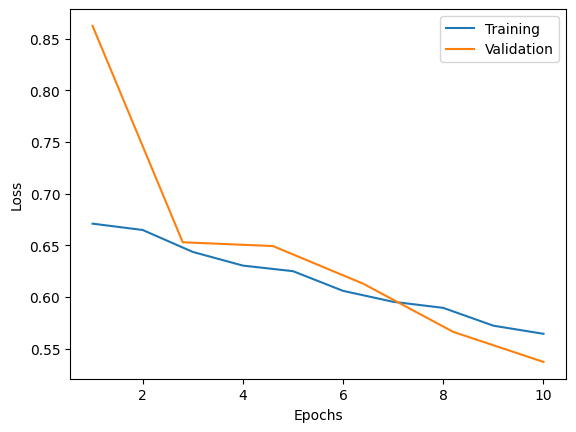

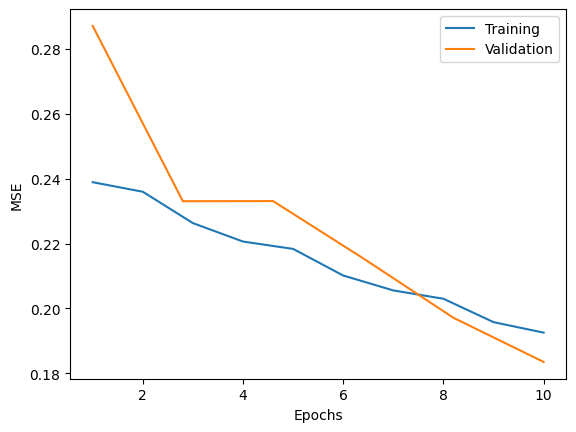

In [ ]:
import matplotlib.pyplot as plt
model.load_state_dict(torch.load(model_path))

if not os.path.isdir(f'output/{model_name}'):
    os.makedirs(f'output/{model_name}')

plt.figure()
plt.plot(np.linspace(1, epochs, len(training_losses)),
         training_losses,
         label='Training')
plt.plot(np.linspace(1, epochs, len(validation_losses)),
         validation_losses,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'output/{model_name}/model_losses.png')

plt.figure()
plt.plot(np.linspace(1, epochs, len(training_metrics)),
         training_metrics,
         label='Training')
plt.plot(np.linspace(1, epochs, len(validation_metrics)),
         validation_metrics,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig(f'output/{model_name}/model_metrics.png')

model.eval()
all_y_true = []
all_y_pred = []
all_y_pred_binary = []
batch = 32

for batch in validation_dataloader:
    X, y = batch['image'], batch['label']
    X, y = X.to(device), y.to(device)
    all_y_true += y.tolist()

    prediction = model(X)
    y_pred = nn.Softmax(dim=1)(prediction)
    all_y_pred += y_pred[:, 1].tolist()
    all_y_pred_binary += y_pred.argmax(1).tolist()

auc = skl_m.roc_auc_score(all_y_true, all_y_pred)
accuracy = skl_m.accuracy_score(all_y_true, all_y_pred_binary)
precision = skl_m.precision_score(all_y_true, all_y_pred_binary)
recall = skl_m.recall_score(all_y_true, all_y_pred_binary)
f1 = skl_m.f1_score(all_y_true, all_y_pred_binary)

print('Final validation metrics')
print(f' AUC: {auc:.4f}')
print(f' Accuracy: {accuracy:.4f}')
print(f' Precision: {precision:.4f}')
print(f' Recall: {recall:.4f}')
print(f' F1: {f1:.4f}')

In [ ]:
import argparse
import glob
import os
import multiprocessing

import pandas as pd
import numpy as np
import sklearn.metrics as skl_m
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms

model_name = "model"
model_path = f'models/{model_name}.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


def load_model(model, model_path):
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        model.to(device)
        print(f'Model loaded from {model_path}')
    else:
        print(f'No model found at {model_path}, starting from scratch.')


train_transform = transforms.Compose([
    DiscreteRotationTransform(angles=[0, -90, 90, 180]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])


n_cpu = multiprocessing.cpu_count()
epochs = 10  # Adjust epochs as needed
batch_size = 640


# Load the model
load_model(model, model_path)

# Setup optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss()
validate_epochs = 2

# Dataset preparation
train_dataset_length = len(glob.glob(path_to_train_images + '/*.jpg'))
rng = np.random.default_rng()
indices = np.arange(0, train_dataset_length)
rng.shuffle(indices, 0)

train_data_length = int(train_dataset_length * 0.75)
validation_data_length = train_dataset_length - train_data_length

train_indices = indices[:train_data_length]
validation_indices = indices[train_data_length:]

train_dataset = OralCancerImageDataset(img_dir=path_to_train_images,
                                       labels_file=path_to_csv,
                                       indices=train_indices,
                                       transform=train_transform)
validation_dataset = OralCancerImageDataset(img_dir=path_to_train_images,
                                            labels_file=path_to_csv,
                                            indices=validation_indices)

training_labels = pd.read_csv(path_to_csv)
sampler_false_weight = np.sum(training_labels.iloc[train_indices]['Diagnosis']) / len(train_indices)
sampler_true_weight = 1 - sampler_false_weight
sampler_weights = np.where(training_labels['Diagnosis'] == 1, sampler_true_weight, sampler_false_weight)
sampler = WeightedRandomSampler(sampler_weights[train_indices], len(train_indices))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_cpu, sampler=sampler)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)

# Training variables
training_losses = np.zeros(epochs)
training_metrics = np.zeros(epochs)
validation_losses = []
validation_metrics = []

best_model_state = None
best_model_metric = 100

# Training loop
for epoch in range(epochs):
    print(f'Running epoch {epoch + 1}')
    training_metrics[epoch], training_losses[epoch] = train(train_dataloader, model, loss_fn, optimizer, device, verbose=True)

    if epoch % validate_epochs == 0 or epoch == epochs - 1:
        validation_metric, validation_loss = validate(validation_dataloader, model, loss_fn, device, verbose=True)
        validation_metrics.append(validation_metric)
        validation_losses.append(validation_loss)

        if validation_metric < best_model_metric:
            print("Saving as best model")
            torch.save(model.state_dict(), model_path)
            best_model_metric = validation_metric
        print("\n")

print('\nTraining complete.\n')


Model loaded from models/model.pth
Running epoch 1
Training loss: 0.387448, Training metric: 0.125211
Validation loss: 0.424862, Validation metric: 0.140095
Saving as best model


Running epoch 2
Training loss: 0.367381, Training metric: 0.117832
Running epoch 3
Training loss: 0.368549, Training metric: 0.118249
Validation loss: 0.358045, Validation metric: 0.117583
Saving as best model


Running epoch 4
Training loss: 0.357371, Training metric: 0.114547
Running epoch 5
Training loss: 0.358428, Training metric: 0.114974
Validation loss: 0.386684, Validation metric: 0.127201


Running epoch 6
Training loss: 0.359074, Training metric: 0.114396
Running epoch 7
Training loss: 0.347496, Training metric: 0.111010
Validation loss: 0.359716, Validation metric: 0.116184
Saving as best model


Running epoch 8
Training loss: 0.343871, Training metric: 0.109788
Running epoch 9
Training loss: 0.356448, Training metric: 0.113799
Validation loss: 0.572376, Validation metric: 0.192617


Running epoch 

In [ ]:
import argparse
import os
import multiprocessing

import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms


model_name = "model"
model_path = f'models/{model_name}.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_cpu = multiprocessing.cpu_count()
batch_size = 128

model = ResConvNeuralNetwork().to(device)

model_path = os.path.join(os.getcwd(), f'models/{model_name}.pth')
data_path = os.path.join(os.getcwd(), 'data')
test_dir = os.path.join(data_path, 'test')
output_dir = f'output/{model_name}'



test_dataset = OralCancerImageDataset(img_dir=path_to_test_images)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=n_cpu)
model = ResConvNeuralNetwork().to(device)
model.load_state_dict(torch.load(model_path))

model.eval()
all_y_pred = []
all_y_names = []

print('Predicting.')

for batch in test_dataloader:
    X = batch['image'].to(device)
    names = batch['label']

    prediction = model(X)
    y_pred = nn.Softmax(dim=1)(prediction)[:, 1]
    all_y_pred += y_pred.tolist()
    all_y_names += names

print('Done.')

prediction_output = pd.DataFrame({'Name': all_y_names,
                                  'Diagnosis': all_y_pred})

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

prediction_output.to_csv(f'{output_dir}/test_prediction.csv', index=False)

Predicting.
Done.
